In [1]:
import os
import datetime
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

In [2]:
server = 'VT3'
schema = 'WCS01600'
features = queries.get_profit_ces_by_day(server, schema)
features.describe().transpose()

count           mean           std         min           25%  \
TYEAR   1300.0    2018.000000      1.405477   2016.0000    2017.00000   
TMON    1300.0       6.529231      3.436198      1.0000       4.00000   
TDAY    1300.0      15.812308      8.747867      1.0000       8.00000   
PROFIT  1300.0  217496.122420  80505.585859 -15223.8972  172522.20545   
CES     1300.0   40190.309654  13842.350155      0.0000   32105.96902   

                 50%            75%           max  
TYEAR     2018.00000    2019.000000    2021.00000  
TMON         7.00000      10.000000      12.00000  
TDAY        16.00000      23.000000      31.00000  
PROFIT  218742.56410  268195.954725  549121.79570  
CES      40190.23616   48512.017145   96539.68725

In [3]:
def year_month_to_date(df):
    df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH'})
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
    df = df.drop(columns=['YEAR', 'MONTH'])
    df.set_index('DATE', inplace=True)
    return df

In [6]:
def year_month_day_to_date(df):
    df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
    df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
    df.set_index('DATE', inplace=True)
    return df

In [7]:
df = year_month_day_to_date(features)

In [10]:
df.describe().transpose().astype(int)

count    mean    std    min     25%     50%     75%     max
PROFIT   1300  217496  80505 -15223  172522  218742  268195  549121
CES      1300   40190  13842      0   32105   40190   48512   96539

In [11]:
df.astype(int)

PROFIT    CES
DATE                     
2016-01-04  117472  22910
2016-01-05  140594  26593
2016-01-06  139909  25070
2016-01-07  190749  38814
2016-01-08  175706  35215
...            ...    ...
2020-12-28  300793  50227
2020-12-29  217491  36745
2020-12-30  233106  40142
2020-12-31  295332  53497
2021-01-04    1128      3

[1300 rows x 2 columns]

In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

print(train_df)
print(val_df)
print(test_df)

              PROFIT       CES
DATE                          
2016-01-04 -1.216451 -1.233917
2016-01-05 -0.903153 -0.950177
2016-01-06 -0.912433 -1.067500
2016-01-07 -0.223568 -0.008712
2016-01-08 -0.427394 -0.285956
...              ...       ...
2019-06-14  1.828278  1.847285
2019-06-17 -0.940144 -0.852042
2019-06-18 -0.078981 -0.248938
2019-06-19  0.945419  0.632115
2019-06-20  1.415521  1.174195

[909 rows x 2 columns]
              PROFIT       CES
DATE                          
2019-06-21  1.732560  1.706484
2019-06-24 -0.764687 -0.810100
2019-06-25  0.800124  0.558987
2019-06-26  2.048990  1.922194
2019-06-27  3.133057  2.892423
...              ...       ...
2020-06-23  1.847530  1.482678
2020-06-24  1.852644  1.500971
2020-06-25  3.113199  3.064170
2020-06-26  2.837997  2.809003
2020-06-29  0.181627  0.563996

[261 rows x 2 columns]
              PROFIT       CES
DATE                          
2020-06-30  1.758645  1.429566
2020-07-01  1.912810  1.556710
2020-07-02  2.929556  

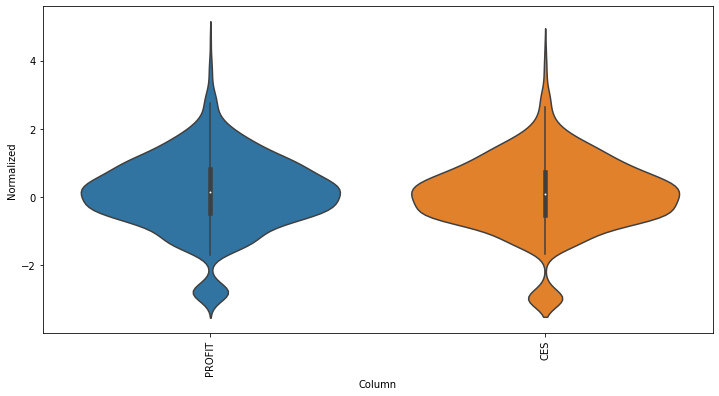

In [14]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [117]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [121]:
w1 = WindowGenerator(input_width=iw, label_width=lw, shift=s,
                     label_columns=['PROFIT'])
w1

Total window size: 899
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [122]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [123]:
# Stack two slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [899,2] != values[1].shape = [809,2] [Op:Pack] name: stack

In [107]:
w1.example = example_inputs, example_labels

In [108]:
def plot(self, model=None, plot_col='PROFIT', max_subplots=2):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [m]')

WindowGenerator.plot = plot

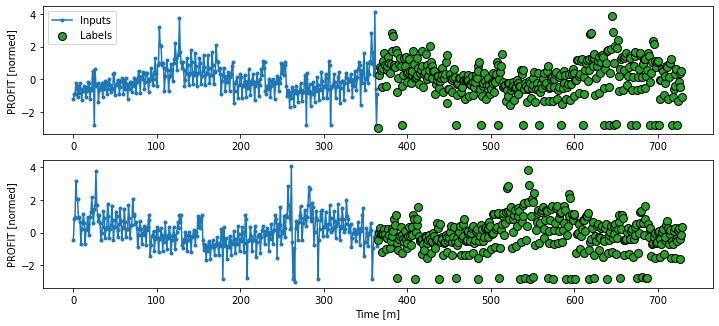

In [109]:
w1.plot()

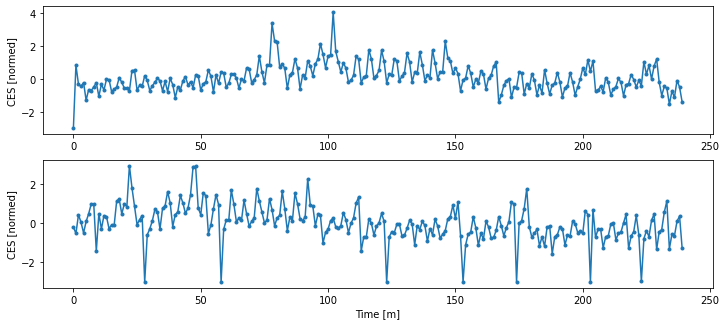

In [90]:
w1.plot(plot_col='CES')

In [91]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [92]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [93]:
# Each element is an (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 240, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None))

In [32]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 240, 2)
Labels shape (batch, time, features): (32, 12, 1)


In [33]:
## Single Step Window Example
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['PROFIT'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['PROFIT']

In [34]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 2)
Labels shape (batch, time, features): (32, 1, 1)


In [35]:
## Baseline class
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [36]:
baseline = Baseline(label_index=column_indices['PROFIT'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

9/9 [==============================] - 0s 996us/step - loss: 1.9687 - mean_absolute_error: 1.0291


In [37]:
wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=['PROFIT'])

wide_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['PROFIT']

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 12, 2)
Output shape: (32, 12, 1)


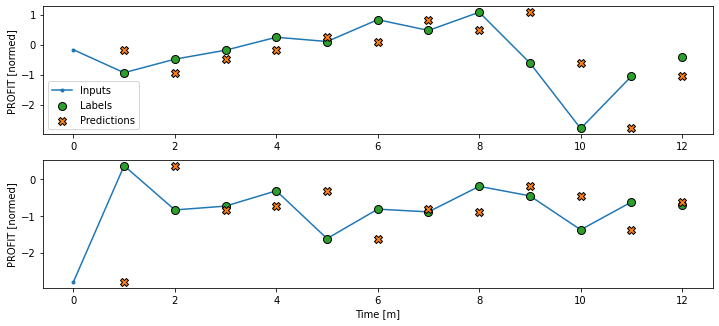

In [39]:
wide_window.plot(baseline)

In [40]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [41]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

<MapDataset shapes: ((None, 1, 2), (None, 1, 1)), types: (tf.float32, tf.float32)>
Epoch 1/50
29/29 [==============================] - 1s 29ms/step - loss: 6.1042 - mean_absolute_error: 1.7617 - val_loss: 7.8609 - val_mean_absolute_error: 2.0660
Epoch 2/50
29/29 [==============================] - 0s 4ms/step - loss: 5.4160 - mean_absolute_error: 1.6984 - val_loss: 7.5404 - val_mean_absolute_error: 2.0185
Epoch 3/50
29/29 [==============================] - 0s 4ms/step - loss: 5.7756 - mean_absolute_error: 1.7274 - val_loss: 7.2216 - val_mean_absolute_error: 1.9702
Epoch 4/50
29/29 [==============================] - 0s 4ms/step - loss: 5.1181 - mean_absolute_error: 1.6536 - val_loss: 6.9286 - val_mean_absolute_error: 1.9250
Epoch 5/50
29/29 [==============================] - 0s 4ms/step - loss: 5.0733 - mean_absolute_error: 1.6221 - val_loss: 6.6417 - val_mean_absolute_error: 1.8801
Epoch 6/50
29/29 [==============================] - 0s 4ms/step - loss: 4.6439 - mean_absolute_error: 1.56

9/9 [==============================] - 0s 998us/step - loss: 1.4925 - mean_absolute_error: 0.9513


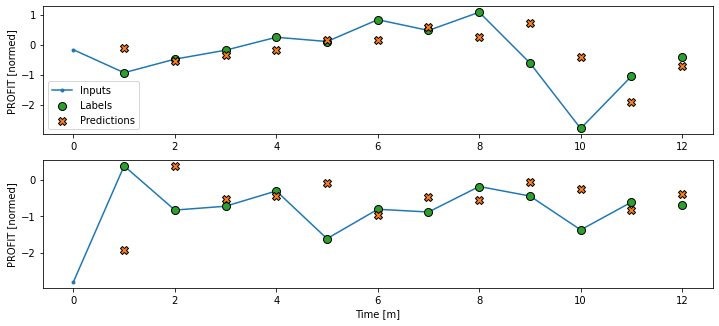

In [42]:
wide_window.plot(linear)

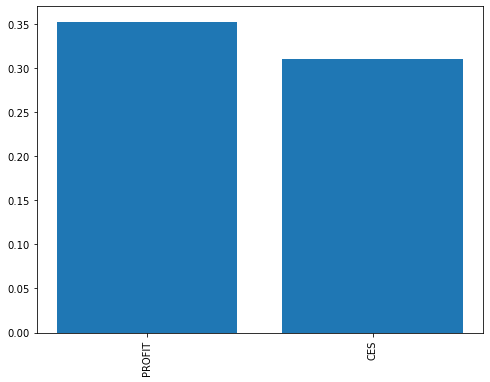

In [43]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [44]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

<MapDataset shapes: ((None, 1, 2), (None, 1, 1)), types: (tf.float32, tf.float32)>
Epoch 1/50
29/29 [==============================] - 1s 9ms/step - loss: 0.9446 - mean_absolute_error: 0.7075 - val_loss: 1.3097 - val_mean_absolute_error: 0.9083
Epoch 2/50
29/29 [==============================] - 0s 4ms/step - loss: 0.8170 - mean_absolute_error: 0.6443 - val_loss: 1.2731 - val_mean_absolute_error: 0.8977
Epoch 3/50
29/29 [==============================] - 0s 4ms/step - loss: 0.7718 - mean_absolute_error: 0.6268 - val_loss: 1.2382 - val_mean_absolute_error: 0.8858
Epoch 4/50
29/29 [==============================] - 0s 4ms/step - loss: 0.8427 - mean_absolute_error: 0.6665 - val_loss: 1.2322 - val_mean_absolute_error: 0.8823
Epoch 5/50
29/29 [==============================] - 0s 4ms/step - loss: 0.7892 - mean_absolute_error: 0.6203 - val_loss: 1.2498 - val_mean_absolute_error: 0.8951
Epoch 6/50
29/29 [==============================] - 0s 4ms/step - loss: 0.8139 - mean_absolute_error: 0.639

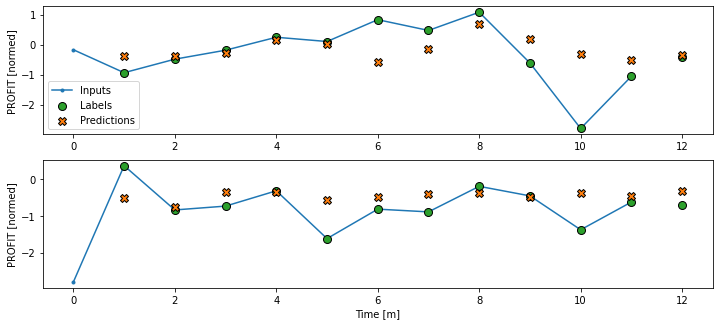

In [45]:
wide_window.plot(dense)

In [46]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['PROFIT'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['PROFIT']

Text(0.5, 1.0, 'Given 3m as input, predict 1m into the future.')

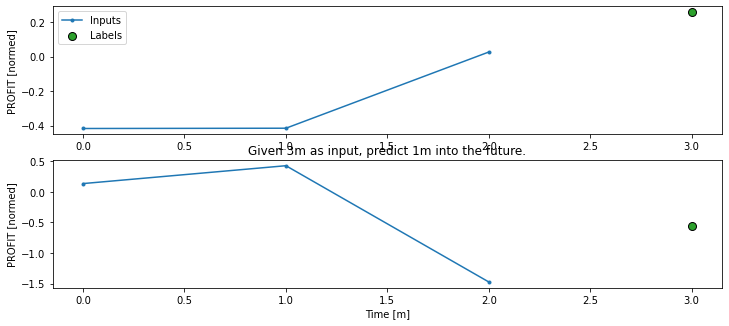

In [47]:
conv_window.plot()
plt.title("Given 3m as input, predict 1m into the future.")

In [48]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [49]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 2)
Output shape: (32, 1, 1)


In [50]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

9/9 [==============================] - 0s 748us/step - loss: 1.0451 - mean_absolute_error: 0.7587


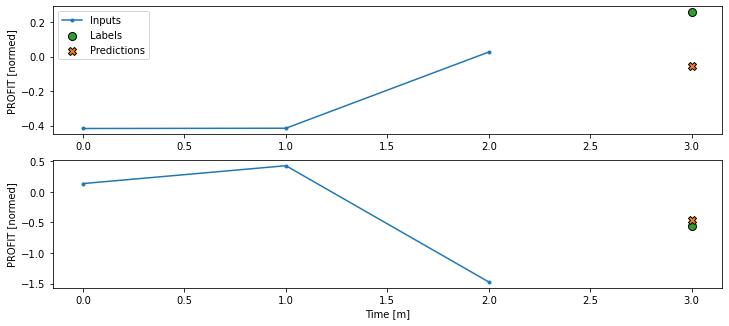

In [51]:
conv_window.plot(multi_step_dense)

In [52]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [53]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 2)
Output shape: (32, 1, 1)


In [54]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

<MapDataset shapes: ((None, 3, 2), (None, 1, 1)), types: (tf.float32, tf.float32)>
Epoch 1/50
29/29 [==============================] - 1s 8ms/step - loss: 0.9308 - mean_absolute_error: 0.7062 - val_loss: 1.3643 - val_mean_absolute_error: 0.8956
Epoch 2/50
29/29 [==============================] - 0s 4ms/step - loss: 0.8023 - mean_absolute_error: 0.6267 - val_loss: 1.2352 - val_mean_absolute_error: 0.8365
Epoch 3/50
29/29 [==============================] - 0s 4ms/step - loss: 0.8375 - mean_absolute_error: 0.6136 - val_loss: 1.2331 - val_mean_absolute_error: 0.8444
Epoch 4/50
29/29 [==============================] - 0s 4ms/step - loss: 0.7775 - mean_absolute_error: 0.5984 - val_loss: 1.2318 - val_mean_absolute_error: 0.8416
Epoch 5/50
29/29 [==============================] - 0s 4ms/step - loss: 0.8058 - mean_absolute_error: 0.6003 - val_loss: 1.2002 - val_mean_absolute_error: 0.8236
Epoch 6/50
29/29 [==============================] - 0s 4ms/step - loss: 0.7551 - mean_absolute_error: 0.579

In [55]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['PROFIT'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['PROFIT']

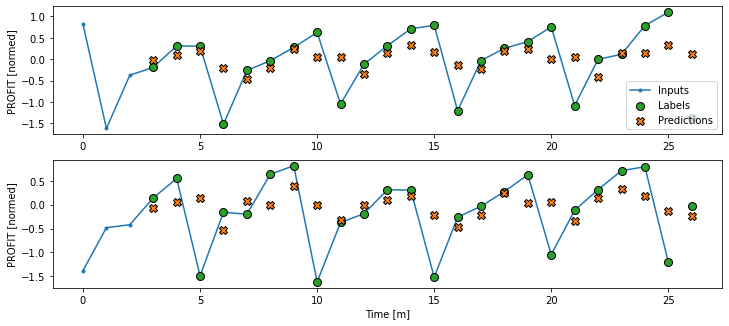

In [56]:
wide_conv_window.plot(conv_model)

In [114]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(50, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [123]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=2)

<MapDataset shapes: ((None, 12, 2), (None, 12, 1)), types: (tf.float32, tf.float32)>
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.2164 - mean_absolute_error: 0.3198
Epoch 2/50
1/1 [==============================] - 0s 73ms/step - loss: 0.2154 - mean_absolute_error: 0.3186
Epoch 3/50
1/1 [==============================] - 0s 70ms/step - loss: 0.2154 - mean_absolute_error: 0.3187
Epoch 4/50
1/1 [==============================] - 0s 76ms/step - loss: 0.2156 - mean_absolute_error: 0.3180
Epoch 5/50
1/1 [==============================] - 0s 86ms/step - loss: 0.2141 - mean_absolute_error: 0.3163
Epoch 6/50
1/1 [==============================] - 0s 74ms/step - loss: 0.2139 - mean_absolute_error: 0.3171
Epoch 7/50
1/1 [==============================] - 0s 77ms/step - loss: 0.2137 - mean_absolute_error: 0.3168
Epoch 8/50
1/1 [==============================] - 0s 86ms/step - loss: 0.2127 - mean_absolute_error: 0.3144
Epoch 9/50
1/1 [==============================] - 0s 

Epoch 34/50
1/1 [==============================] - 0s 79ms/step - loss: 0.2023 - mean_absolute_error: 0.2990
Epoch 35/50
1/1 [==============================] - 0s 77ms/step - loss: 0.2019 - mean_absolute_error: 0.2983
Epoch 36/50
1/1 [==============================] - 0s 79ms/step - loss: 0.2014 - mean_absolute_error: 0.2973
Epoch 37/50
1/1 [==============================] - 0s 75ms/step - loss: 0.2010 - mean_absolute_error: 0.2963
Epoch 38/50
1/1 [==============================] - 0s 84ms/step - loss: 0.2006 - mean_absolute_error: 0.2955
Epoch 39/50
1/1 [==============================] - 0s 86ms/step - loss: 0.2002 - mean_absolute_error: 0.2949
Epoch 40/50
1/1 [==============================] - 0s 76ms/step - loss: 0.1998 - mean_absolute_error: 0.2946
Epoch 41/50
1/1 [==============================] - 0s 71ms/step - loss: 0.1993 - mean_absolute_error: 0.2940
Epoch 42/50
1/1 [==============================] - 0s 74ms/step - loss: 0.1989 - mean_absolute_error: 0.2932
Epoch 43/50
1/1 [==

ZeroDivisionError: float division by zero

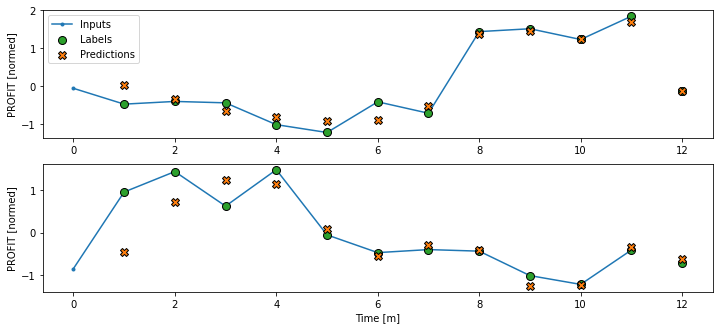

In [124]:
wide_window.plot(lstm_model)

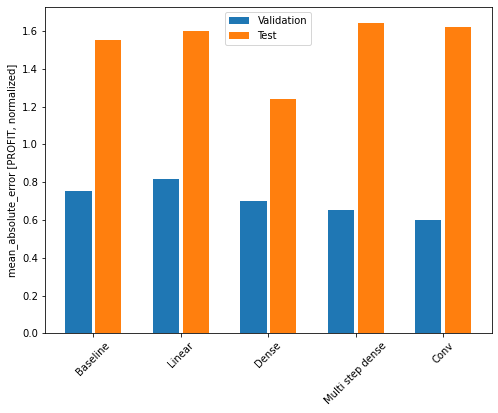

In [125]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [PROFIT, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [126]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 1.5528
Linear      : 1.6015
Dense       : 1.2405
Multi step dense: 1.6435
Conv        : 1.6180
